In [1]:
import torch
import torch.nn as nn

import pandas as pd
import numpy as np

In [2]:
from bayes_flow import BayesFlow
from summary_network import SummaryNet

In [3]:
hyperparams = {
    'n_blocks': 8,
    'n_layers': 3,
    'n_units': 196,
    'activation': nn.ELU
}

x_dim = 192
theta_dim = 31

in_channels = 21

print("Build BaysFlow model")
summary_net = SummaryNet(in_channels, x_dim, 3)
model = BayesFlow(hyperparams, theta_dim, x_dim, summary_net=summary_net)

Build BaysFlow model


In [4]:
saved_model = torch.load("germany_vaccine_16322152166268163_checkpoint.pt", map_location='cpu')[0]

In [5]:
model.load_state_dict(saved_model)

<All keys matched successfully>

In [6]:
model.eval()
print()

In [7]:
def load_data(begin_date="2020-03-02", end_date="2020-05-21", country="Germany"):
    # Read data from csv, first columns is index
    # (indexed by dates)
    data = pd.read_csv(f"data/{country.capitalize()}.csv", index_col=0)
    #data = data[begin_date:end_date]
    
    # Don't do the reshape now, but later using `normalise`
    # So we treat the real data just like synthetic data from simulator
    new_I = data["Confirmed"].to_numpy(dtype=np.int64)
    new_R = data["Recovered"].to_numpy(dtype=np.int64)
    new_D = data["Deaths"].to_numpy(dtype=np.int64)
    new_V = data["People_fully_vaccinated"].to_numpy(dtype=np.int64)
    
    data = np.stack([new_I, new_R, new_D, new_V]).T
    
    #if args.max_days is not None:
    #    data = data[:args.max_days, :]
    
    # If necessary, truncate s.t. T is multiple of 7
    #if args.weekly:
    leftover_days = data.shape[0] % 7
    data = data[:-leftover_days, :]
    
    assert data.shape[0] % 7 == 0

    return data

In [8]:
data = load_data()

In [9]:
data.shape

(553, 4)

In [10]:
import matplotlib.pyplot as plt

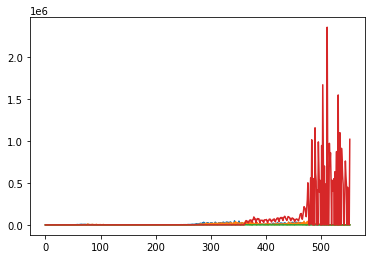

In [11]:
plt.plot(data)
plt.show()

In [12]:
from exact_vaccination_epidemic_model import sample_simulation

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from scipy import stats
from functools import partial
np.set_printoptions(suppress=True)
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.stats import binom

In [14]:
import warnings
warnings.filterwarnings("ignore")

In [15]:
T = data.shape[0]
N_germany = 83e6
mean_g = np.mean(data, axis=0)
std_g = np.std(data, axis=0)

In [16]:
param_names = [r'$E_0$',
               r'$\beta$', r'$\gamma$', r'$\alpha$', r'$\eta$', r'$\theta$', r'$\delta$', r'$\mu$', r'$d$',
               r'$\beta_V$', r'$\gamma_V$', r'$\alpha_V$', r'$\eta_V$', r'$\theta_V$', r'$\delta_V$',
               r'$\mu_V$', r'$d_V$', r'$\xi$',
               r'$A_I$', r'$A_R$', r'$A_D$',
               r'$\Phi_I$', r'$\Phi_R$', r'$\Phi_D$',
               r'$D_I$', r'$D_R$', r'$D_D$',
               r'$\sigma_I$', r'$\sigma_R$', r'$\sigma_D$',
               r'$\lambda_0$'
              ]

assert len(param_names) == 31

param_keys = ['E0', 'beta', 'gamma', 'alpha', 'eta', 'theta', 'delta', 'mu', 'd',
              'betaV', 'gammaV', 'alphaV', 'etaV', 'thetaV', 'deltaV', 'muV', 'dV',
              'xi',
              'As', 'Phis', 'Ds', 'sigma',
              'lambda_start']

param_lengths = [1] * 18 + [3] * 4 + [1]
assert sum(param_lengths) == 31

def vector2params(param_vector):
    params = dict()
    start = 0
    
    for param_name, param_length in zip(param_keys, param_lengths):
        params[param_name] = param_vector[start:start+param_length]
        if param_length == 1:
            params[param_name] = params[param_name].item()
        start = start + param_length
    
    assert start == len(param_vector)
        
    params['Ds'] = params['Ds'].astype(np.int64)
    
    return params

In [17]:
def plot_predictions_future(n_samples, 
                            data, 
                            data_pred,
                            N_sim,
                            T,
                            logscale=True, 
                            sim_diff=16, 
                            plot_quantiles=True, 
                            figsize=(24, 8), 
                            cumulative=False,
                            filename=None,
                            font_size=18):
    """Plots the posterior predictive."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g
    infected = norm_data[:, 0:1].reshape(norm_data.shape[0] // 7, 7)
    recovered = norm_data[:, 1:2].reshape(norm_data.shape[0] // 7, 7)
    dead = norm_data[:, 2:3].reshape(norm_data.shape[0] // 7, 7)
    #vaccinated = np.diff(norm_data[:, 3:], axis=0, prepend=0).reshape(norm_data.shape[0] // 7, 7)
    norm_data = np.concatenate([infected, recovered, dead], axis=-1)
    
    #norm_data = normalise(data, 83e6, weekly=True)
    samples = model.sample(torch.from_numpy(norm_data).float().unsqueeze(0), n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if "Phi" not in e]
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    print('Number of valid samples: ', samples.shape[0])
    f, ax = plt.subplots(1, 3, figsize=figsize)
    sims = []
    rej = 0
    for i in range(samples.shape[0]):
        try:
            simulation = sample_simulation(N_sim, data, T=T, params=vector2params(samples[i]))
            sims.append(simulation['observed_data'])
        except:
            rej += 1
    sims = np.array(sims)
    print('Number of rejected simulations: ', rej)
    
    if cumulative:
        sims = np.cumsum(sims, axis=1)
        
    meds = np.median(sims, axis=0)
    
    if cumulative:
        titles = ['Cumulative Infected', 'Cumulative Recovered', 'Cumulative Dead']
    else:
        titles = ['New Infected', 'New Recovered', 'New Dead']
        
    colors = ['Blue', 'Green', '#911a20', 'Red']
    
    # Compute quantiles
    qs_50 = np.quantile(sims, q=[0.25, 0.75], axis=0)
    qs_90 = np.quantile(sims, q=[0.05, 0.95], axis=0)
    qs_95 = np.quantile(sims, q=[0.025, 0.975], axis=0)
    
    
    for i in range(3):
        if cumulative:
            ax[i].plot(np.cumsum(data_pred[:, i], axis=0), 
                       marker='o', label='Reported cases', color='black', linestyle='dashed', alpha=0.8)
        else:
            ax[i].plot(data_pred[:, i], marker='o', 
                       label='Reported cases', 
                       color='black', linestyle='dashed', alpha=0.8)
        
        #ax[i].axvline(data[:, i].shape[0], color='black', alpha=0.8, linestyle='dashed')
        
        # Plot median cases
        ax[i].plot(meds[:, i], label='Median predicted cases', color=colors[i], lw=3)
        
        if plot_quantiles:
            ax[i].fill_between(range(T), qs_50[0, :, i], qs_50[1, :, i], color=colors[i], alpha=0.3, label='50% CI')
            ax[i].fill_between(range(T), qs_90[0, :, i], qs_90[1, :, i], color=colors[i], alpha=0.2, label='90% CI')
            ax[i].fill_between(range(T), qs_95[0, :, i], qs_95[1, :, i], color=colors[i], alpha=0.1, label='95% CI')
        ax[i].spines['right'].set_visible(False)
        ax[i].set_title(titles[i], pad=0.2)
        ax[i].spines['top'].set_visible(False)
        ax[i].set_xlabel('Days')
        ax[i].set_ylabel('Number of cases')
        ax[i].legend(loc='upper left')
        ax[i].set_ylim([0, np.max(qs_95[1, :, i])*1.5])
        #ax[i].set_xticks([6, 20, 34, 48, 62, 76, 90])
        ax[i].grid(color='grey', linestyle='-', linewidth=0.25, alpha=0.5)
        #ax[i].set_xticklabels(['Mar 8', 'Mar 22', 'Apr 5', 'Apr 19', 'May 3', 'May 17', 'May 31'], rotation=45)
        #ylabels = ['{:,.1f}'.format(x) + 'K' for x in ax[i].get_yticks()/1000]
        #ax[i].set_yticklabels(ylabels)
        
        if logscale:
            ax[i].set_yscale('log')
    f.tight_layout()
    plt.show()
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300)

Number of valid samples:  4374
Number of rejected simulations:  0


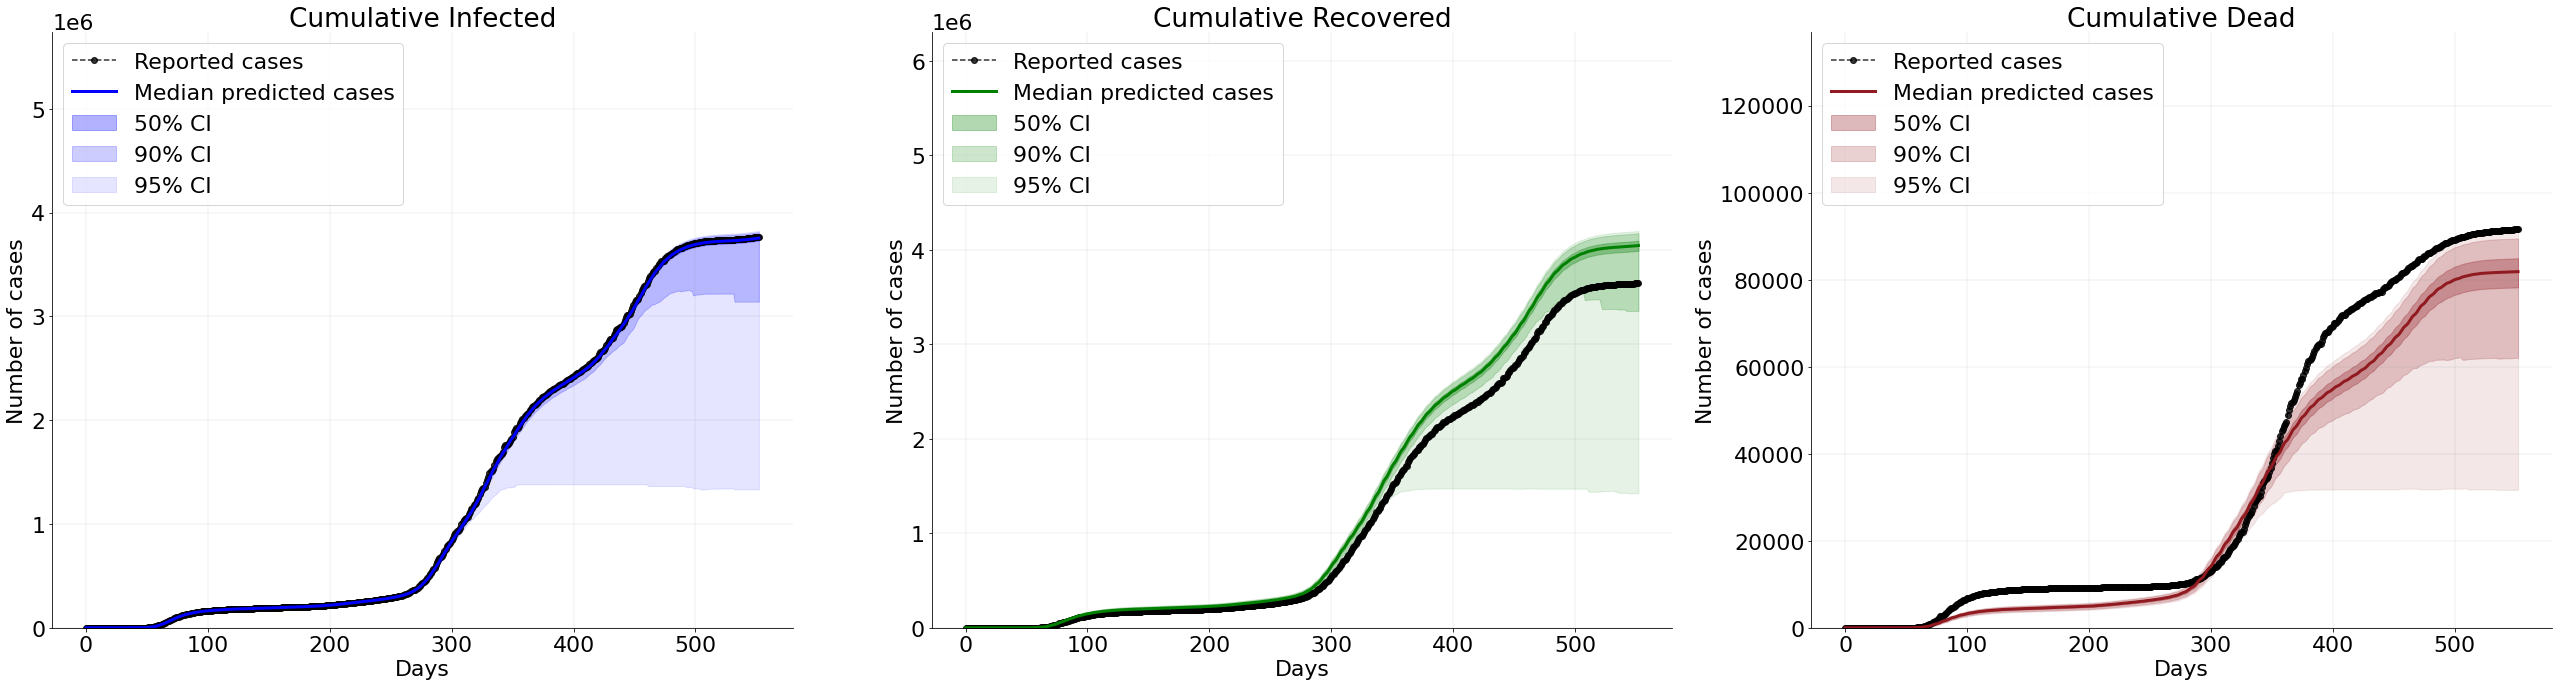

In [18]:
plot_predictions_future(5000,
                 data,
                 data,
                 N_germany, 
                 data.shape[0],
                 logscale=False, 
                 sim_diff=16,
                 cumulative=True, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename="Exact_Vaccine_Predicted_Cumulative_Germany")

Number of valid samples:  4316
Number of rejected simulations:  0


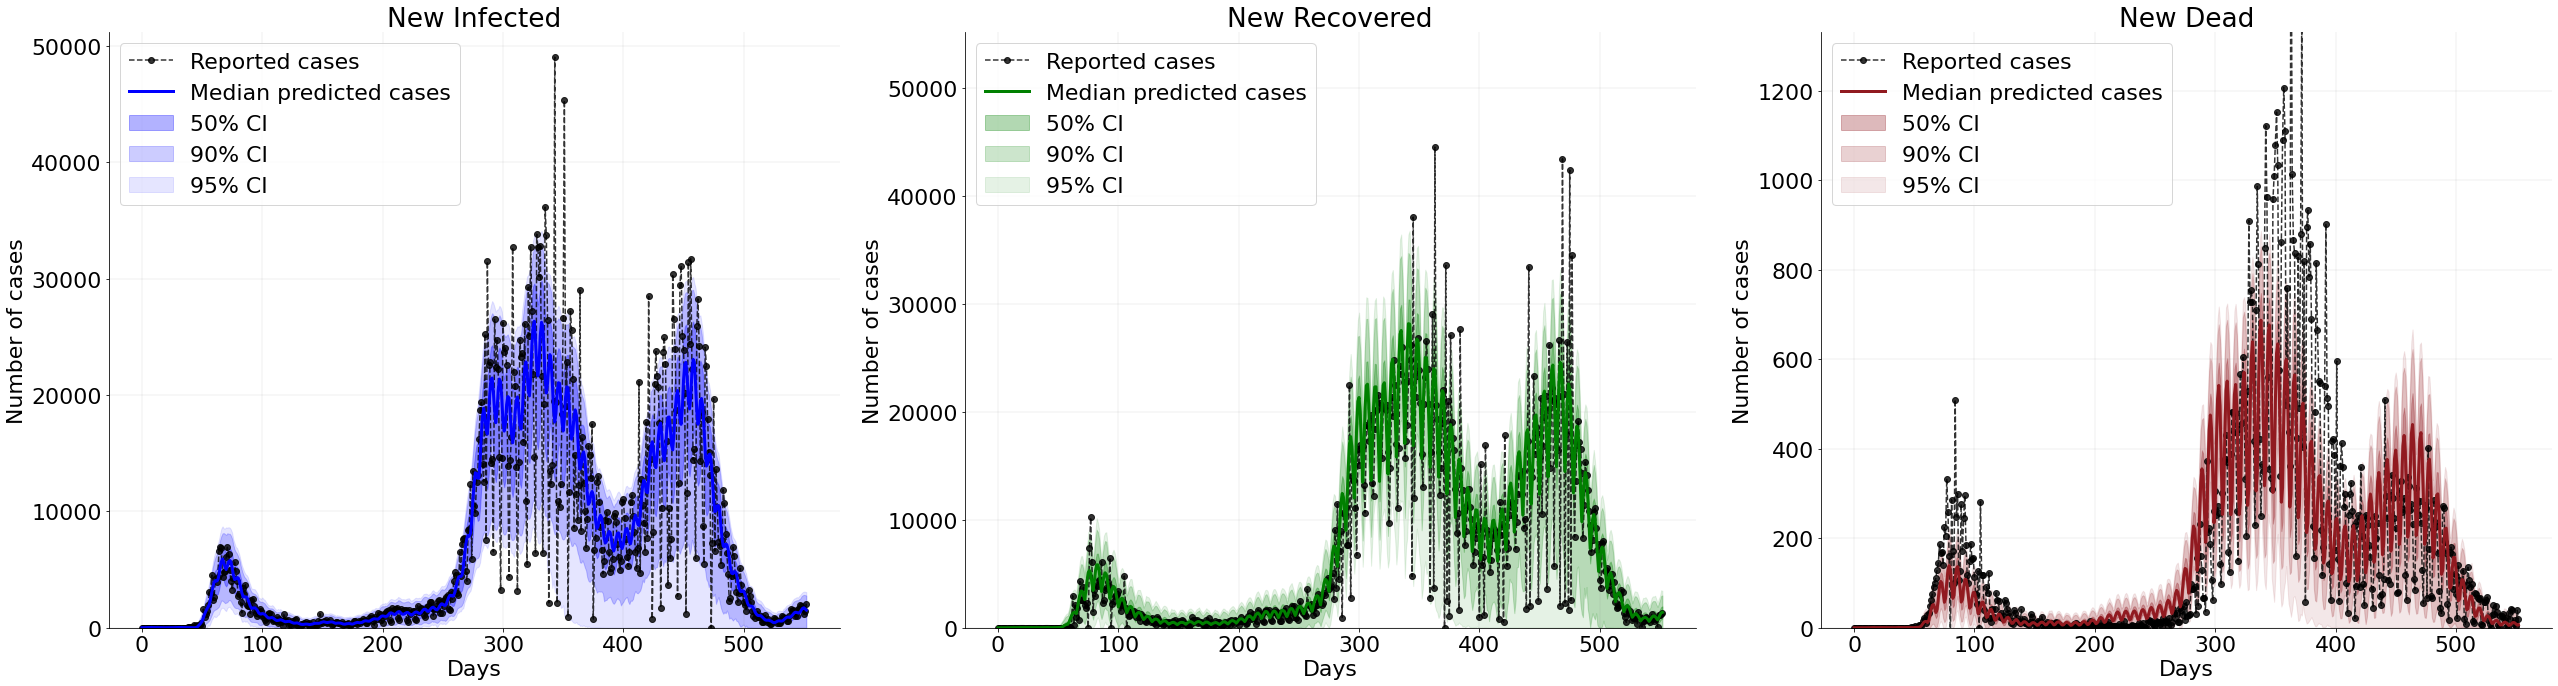

In [19]:
plot_predictions_future(5000,
                 data,
                 data,
                 N_germany,
                 data.shape[0],
                 logscale=False, 
                 sim_diff=16, 
                 cumulative=False, 
                 figsize=(36, 10), 
                 font_size=22,
                 filename="Exact_Vaccine_Predicted_New_Germany")

In [20]:
from sklearn.neighbors import KernelDensity

def estimate_map(samples):
    
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    scores = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1)).score_samples(samples.reshape(-1, 1))
    max_i = scores.argmax()
    map_i = samples[max_i]
    return map_i


def get_kde(samples):
    """Returns sorted kdes."""
    bw = 1.06 * samples.std() * samples.size ** (-1 / 5.)
    kde = KernelDensity(bandwidth=bw).fit(samples.reshape(-1, 1))
    x_plot = np.linspace(samples.min(), samples.max(), 10000)
    y_plot = np.exp(kde.score_samples(x_plot[:, np.newaxis]))
    return x_plot, y_plot

def plot_posteriors_germany(n_samples, 
                            data, 
                            figsize=(22, 12), 
                            font_size=16, 
                            filename=None, 
                            bins=30,
                            map_samples=5000):
    """Plots univariate posteriors."""
    
    # Plot settings
    plt.rcParams['font.size'] = font_size
    
    norm_data = (data - mean_g) / std_g
    infected = norm_data[:, 0:1].reshape(norm_data.shape[0] // 7, 7)
    recovered = norm_data[:, 1:2].reshape(norm_data.shape[0] // 7, 7)
    dead = norm_data[:, 2:3].reshape(norm_data.shape[0] // 7, 7)
    #vaccinated = np.diff(norm_data[:, 3:], axis=0, prepend=0).reshape(norm_data.shape[0] // 7, 7)
    
    norm_data = np.concatenate([infected, recovered, dead], axis=-1)
    
    #norm_data = normalise(data, 83e6, weekly=True)
    samples = model.sample(torch.from_numpy(norm_data).float().unsqueeze(0), n_samples, to_numpy=True)
    idx_nonzero = [i for i, e in enumerate(param_names) if "Phi" not in e]
    samples = samples[np.sum(samples[:, idx_nonzero] < 0, axis=1) == 0]
    idx_alpha = param_names.index('$\\alpha$')
    print('Number of valid samples: ', samples.shape[0])
    f, ax = plt.subplots(6, 6, figsize=figsize)
    for i in range(samples.shape[1]):
        
        x_fill, y_fill = get_kde(prior_samples[:, i])
        ax.flat[i].plot(x_fill, y_fill, alpha=0.5, color='gray', lw=3, label='Prior')
        sns.histplot(samples[:, i], kde=False, bins=bins, ax=ax.flat[i], stat='density',
                     color='#a34f4f', element='step', label='Posterior')
        
        ax.flat[i].spines['right'].set_visible(False)
        ax.flat[i].spines['top'].set_visible(False)
        ax.flat[i].axvline(np.median(samples[:, i]), color='black', linestyle='dashed')
        ax.flat[i].set_title(param_names[i], pad=0.4)
        ax.flat[i].set_ylim([0, ax.flat[i].get_ylim()[1]])
        if i == idx_alpha:
            align = 'right'
            xx = 0.4
        else:
            align = 'left'
            xx = 0.7
            
        # Change points
        #if i < 4:
        #    
        #    tick_std = np.std(prior_samples[:, i])
        #    tick_mean = np.mean(prior_samples[:, i])
        #    ax.flat[i].set_xticks([tick_mean-1.98*tick_std, tick_mean, tick_mean+1.98*tick_std])
        #    ax.flat[i].set_xticklabels([days[int(round(tick_mean - 1.98*tick_std))], 
        #                                days[int(round(tick_mean))], 
        #                                days[int(round(tick_mean + 1.98*tick_std))]], rotation=30)
        #    
        if i == 0:
            lg = f.legend(loc='lower right', bbox_to_anchor=(0.9, 0.04), 
                          ncol=5, fontsize=20, borderaxespad=1)
            
        med = np.median(samples[:, i])
        MAP = estimate_map(samples[:map_samples, i])
        ax.flat[i].text(xx, 0.85, r'$MAP={:.2f}$'.format(MAP),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        ax.flat[i].text(xx, 0.6, r'$Med={:.2f}$'.format(med),
                     horizontalalignment=align,
                     verticalalignment='center',
                     transform=ax.flat[i].transAxes,
                     size=12)
        
        ax.flat[i].set_ylabel('')
        ax.flat[i].set_yticks([])
        
    for k in range(5):
        ax.flat[i+k+1].axis('off')
    f.tight_layout()
    plt.show()
    
    # Save if specified
    if filename is not None:
        f.savefig("figures/{}.png".format(filename), dpi=300,  
                  bbox_extra_artists=(lg,), bbox_inches='tight')

In [21]:
from exact_vaccination_epidemic_model import prior, params2vector

In [22]:
days = ['March {}'.format(i) for i in range(1, 32)] + \
       ['April {}'.format(i) for i in range (1, 31)] + \
       ['May {}'.format(i) for i in range(1, 21)]

In [23]:
n_prior_samples = 5000
prior_samples = np.stack([params2vector(prior()) for _ in range(n_prior_samples)])

Number of valid samples:  65055


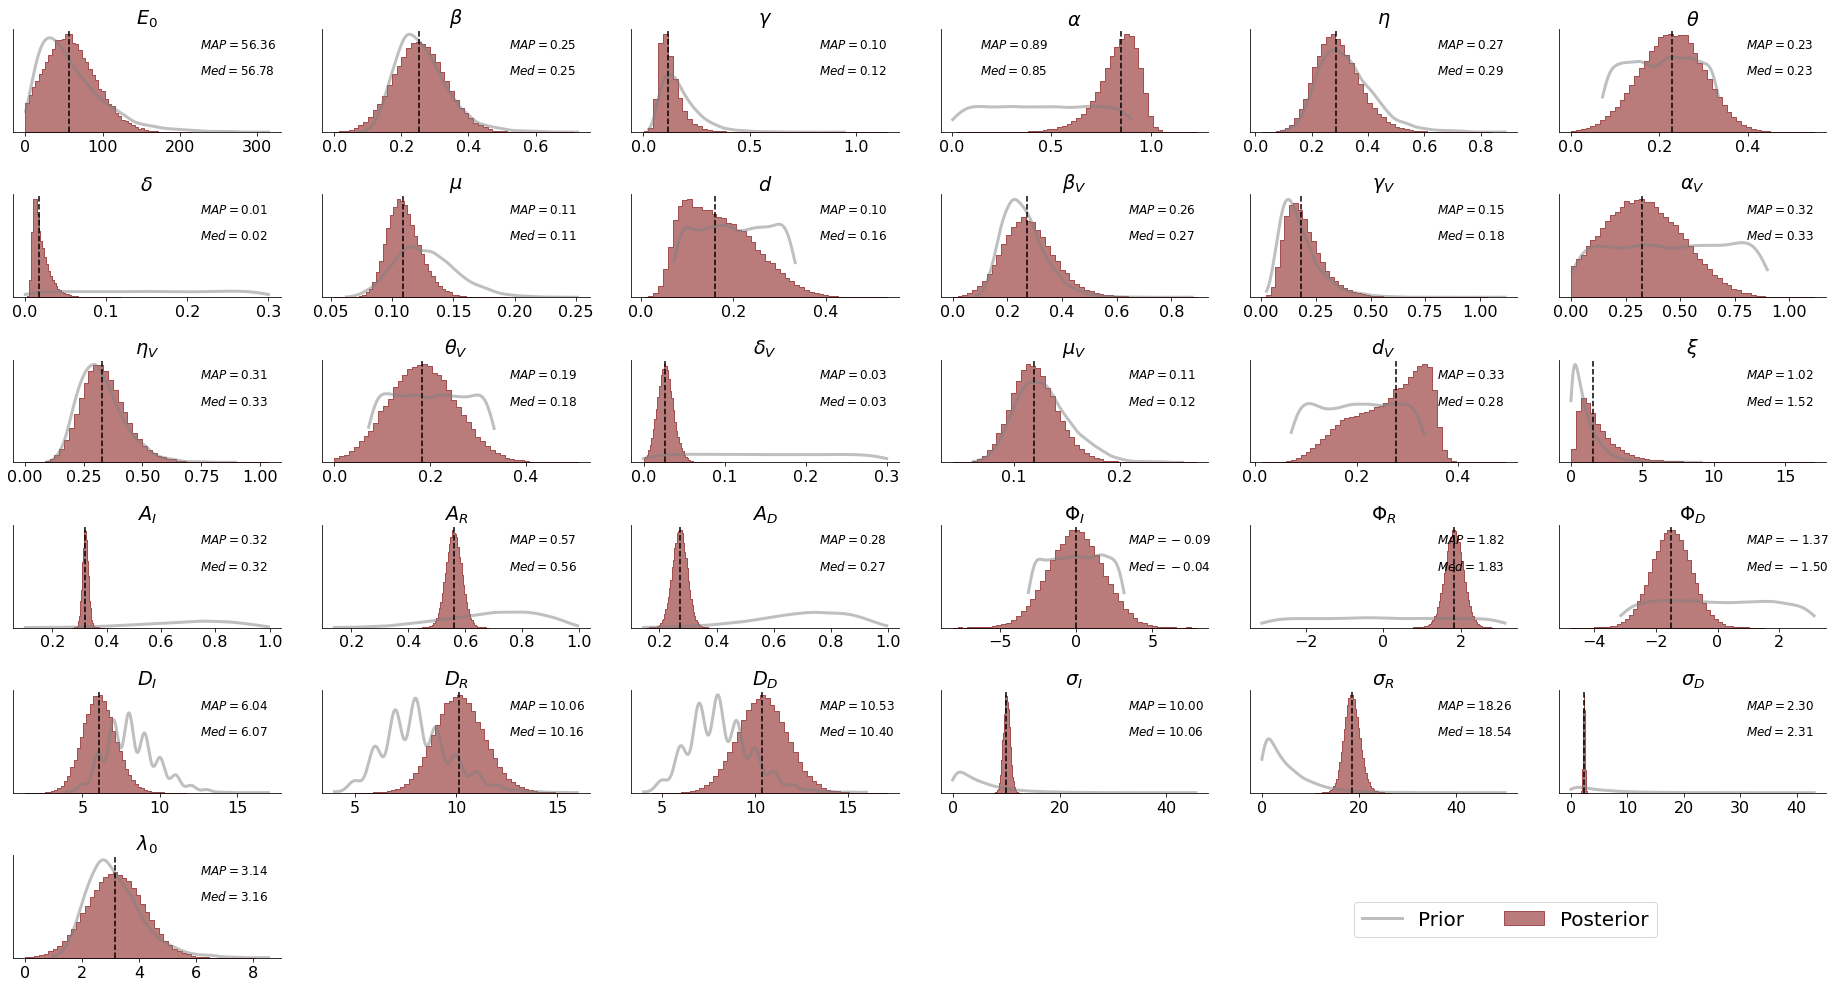

In [24]:
plot_posteriors_germany(75000, 
                        data,
                        bins=50, figsize=(26, 14), 
                        filename='Exact_Vaccine_Marginal_Posteriors_Germany', 
                        map_samples=10000)